# Исследование компьютерных игр

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Исследование включает:
 1. Загрузку данных и их предварительное изучение;
 2. Подготовку данных;
 3. Исследовательский анализ данных;
 4. Составление портрета пользователя каждого региона;
 5. Проверку гипотез;
 6. Вывод исследования.

## Загрузка данных и их предварительное изучение

In [1]:
import missingno as msno
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import warnings
import re
from itertools import chain
from scipy import stats as st
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

In [2]:
try:
    data = pd.read_csv('/datasets/games.csv')
except:
    data = pd.read_csv('games.csv')

In [3]:
data.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В данных 16715 строчек. Много пропусков в столбцах оценок критиков, пользовательских оценок и возрастного рейтинга, есть незначительные пропуски в столбце годов выпуска. Данные в годах выпуска представлены в формател float, а в пользовательских оценках object (str), что необходимо исправить.

##  Подготовка данных

1. Заменим названия столбцов (приведем к нижнему регистру);
2. Преобразуем данные в нужные типы;
3. Обработаем пропуски;
4. Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.

### Переименование столбцов

Заменим название столбцов - приведем к нижнему регистру.

In [5]:
data.columns = data.columns.str.lower()
data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


### Преобразование типов данных

Переведем значения года выпуска в целочисленный формат, предварительно заменив пропуски значений в столбце на 0.

In [6]:
print(data['year_of_release'].isna().sum())
data['year_of_release'] = data['year_of_release'].fillna(0).astype(int)
data['year_of_release'].unique()

269


array([2006, 1985, 2008, 2009, 1996, 1989, 1984, 2005, 1999, 2007, 2010,
       2013, 2004, 1990, 1988, 2002, 2001, 2011, 1998, 2015, 2012, 2014,
       1992, 1997, 1993, 1994, 1982, 2016, 2003, 1986, 2000,    0, 1995,
       1991, 1981, 1987, 1980, 1983])

Пропусков в годах выпуска 269.

tbd ("подлежит уточнению") в рейтинге пользователей является пропуском.

In [7]:
data.loc[data['user_score'] == 'tbd']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,0,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


Преобразуем строковые значения пользовательского рейтинга в числовые значения, а tbd в nan.

In [8]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')
data['user_score']

0        8.0
1        NaN
2        8.3
3        8.0
4        NaN
        ... 
16710    NaN
16711    NaN
16712    NaN
16713    NaN
16714    NaN
Name: user_score, Length: 16715, dtype: float64

### Обработка пропусков

In [9]:
data.isna().sum()

name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

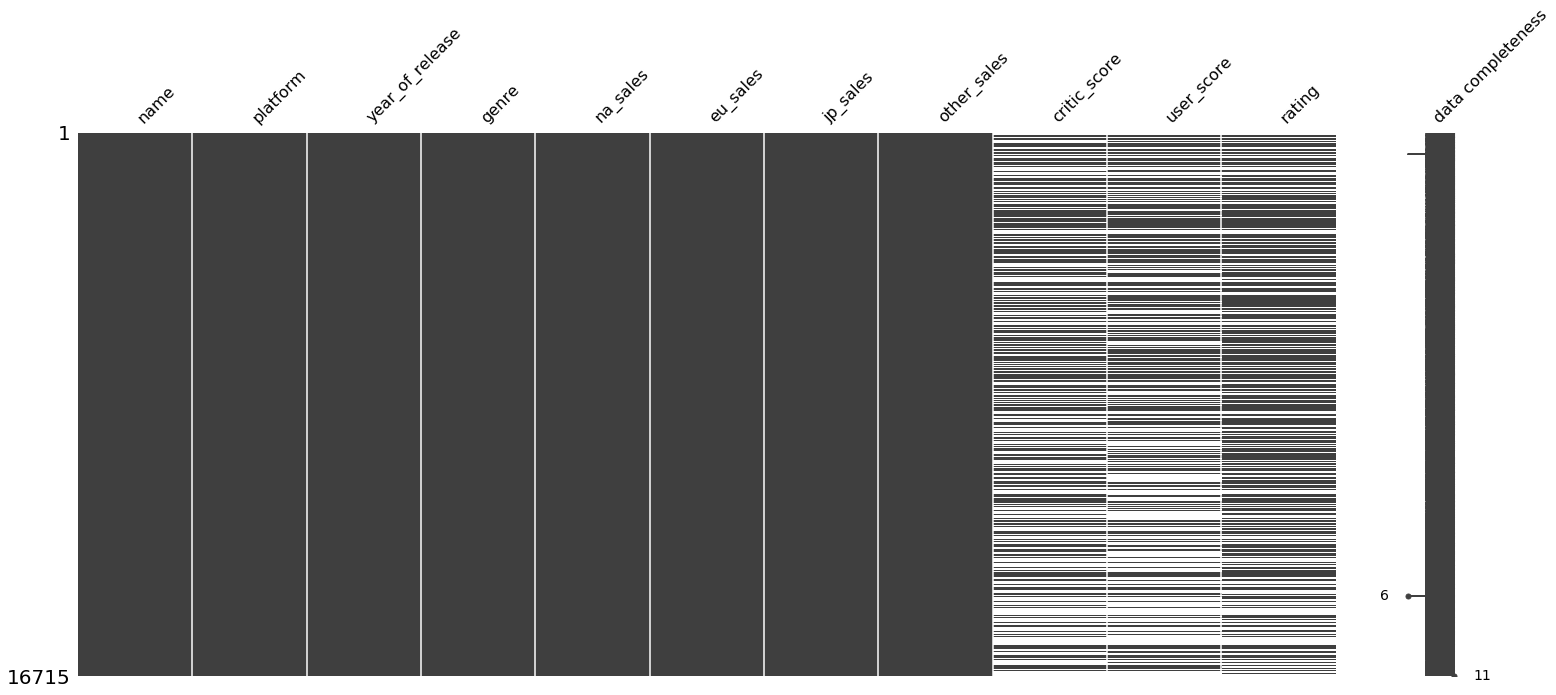

In [10]:
msno.matrix(data, labels=True);

In [11]:
data.loc[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Пропуски в названии и жанре игры одни и те же. Заполнить пропуски невозможно, удаляем.

In [12]:
data = data.drop(labels=[659,14244], axis=0)

Определим игры, которые имеют пропуски в рейтингах на некоторых платформах, но имеют значения на других.

In [13]:
name_score_loss = {}
rating = ['critic_score', 'user_score', 'rating']
for i in rating:
    name_score_loss[i] = data.loc[data[i].isna(),'name'].unique()

In [14]:
rating_other_platform = {}
for i in rating: 
    for name in name_score_loss[i]:
        if data.loc[(data['name'] == name) & (~data[i].isna()),'name'].count() > 0:
            if rating_other_platform.get(i) is None:
                rating_other_platform[i] = [name]
            else:
                rating_other_platform.get(i).append(name)

In [15]:
for i in rating:
    print(len(rating_other_platform[i]))

648
767
359


Таким образом, в столбцах 'critic_score', 'user_score', 'rating' соответвстенно 648, 767 и 359 именований игр с пропусками, но имеющие рейтинги на других платформах. Заполним эти пропуски средним значением, а 'rating' - модой. 

In [16]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [17]:
data[data.duplicated(subset=['name', 'platform'], keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
1190,Need for Speed: Most Wanted,X360,2012,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1745,Sonic the Hedgehog,PS3,2006,Platform,0.41,0.06,0.04,0.66,43.0,4.1,E10+
4127,Sonic the Hedgehog,PS3,0,Platform,0.00,0.48,0.00,0.00,43.0,4.1,E10+
5972,Need for Speed: Most Wanted,PC,2005,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
11715,Need for Speed: Most Wanted,PC,2012,Racing,0.00,0.06,0.00,0.02,82.0,8.5,T
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E


In [18]:
data = data.drop(labels=[4127, 16230], axis=0)

In [19]:
print(len(data.loc[data['year_of_release'] == 0]))
re_year = pd.DataFrame(chain(*data.loc[(data['year_of_release'] == 0) & \
                        (data['name'].str.contains('\d{4}', regex=True)), 'name']
                        .str.findall('\d{4}'))).astype(int)[0]
data.loc[(data['year_of_release'] == 0) & \
         (data['name'].str.contains('\d{4}', regex=True)), 'year_of_release'] = re_year
print(len(data.loc[data['year_of_release'] == 0]))
re_year

268
251


0     2004
1     2004
2     2006
3     2003
4     2009
5     2002
6     2003
7     2003
8     2013
9     2005
10    2003
11    2005
12    2011
13    2006
14    2008
15    2007
16    2008
Name: 0, dtype: int32

Таким образом заменили пропуски в годах выпуска 17 игр по году выпуска указанному в названии игры. Остальные пропуски заполнять по аналогии с рейтингом на других платформах не рационально, можно исказить данные из-за выпусков ремастеров, разных версий игр.

### Суммарные продажи

In [20]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [21]:
data.isna().sum()

name                  0
platform              0
year_of_release      17
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         9123
rating             6764
total_sales           0
dtype: int64

### Вывод по разделу

Были преименованы столбцы и изменены типы данных в годах выпуска на целочисленный и рейтинг пользователей на числовой с плавающей точкой, для удобства дальнейших расчетов. Значения tbd были заменены на значение nan при изменении типа данных.

Пропуски в рейтингах были заменены у заполнены у тех игр, у которых есть рейтинг на других платформах - модой по возрастному рейтингу и средним по остальным. В других случаях, при заполнении пропусков синтетическими значениями, может быть сильное искажение от реальности.

Были удалены дубликаты. NFS разных годов выпуска - рейтинги были заполнены средним по другой платформе, дубликатами не являются.

Посчитаны суммарные продажи во всех регионах и записаны в столбец "total_sales".

## Исследовательский анализ

### Игры и платформы

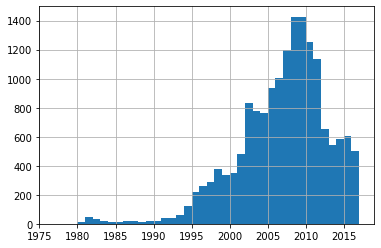

In [22]:
data['year_of_release'].hist(bins=40, range=(1977,2017));

In [23]:
top_platforms = data.pivot_table(index='platform', values='total_sales', aggfunc=['sum']).reset_index()
top_platforms.columns = ['platform', 'total_sales']
top_platforms = top_platforms.sort_values(by='total_sales', ascending=False).reset_index(drop=True)
top_platforms = top_platforms[0:6]
top_platforms

,platform,total_sales
0,PS2,1255.77
1,X360,971.42
2,PS3,939.16
3,Wii,907.51
4,DS,806.12
5,PS,730.86


In [24]:
top_pl_for_years = data.pivot_table(index=['platform', 'year_of_release'], \
                                           values='total_sales', aggfunc=['sum']).reset_index()
top_pl_for_years.columns = ['platform', 'year_of_release', 'total_sales']
top_pl_for_years = top_pl_for_years.loc[top_pl_for_years['year_of_release'] > 0] 
top_pl_for_years    

,platform,year_of_release,total_sales
1,2600,1980.0,11.38
2,2600,1981.0,35.68
3,2600,1982.0,28.88
4,2600,1983.0,5.84
5,2600,1984.0,0.27
...,...,...,...
249,XB,2008.0,0.18
250,XOne,2013.0,18.96
251,XOne,2014.0,54.07
252,XOne,2015.0,60.14


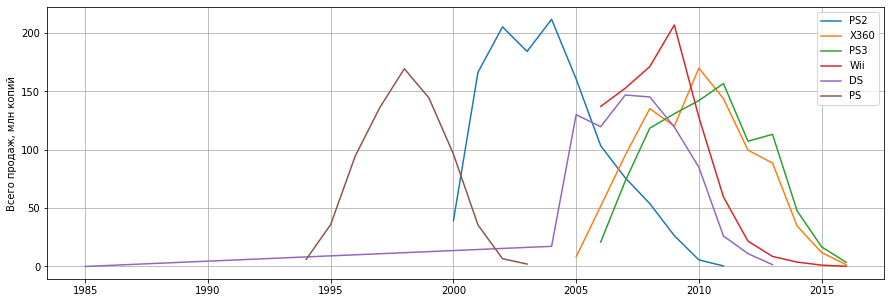

In [25]:
plt.figure(figsize=(15, 5))
for i in top_platforms['platform']:
    X = top_pl_for_years.loc[top_pl_for_years['platform'] == i, 'year_of_release']
    Y = top_pl_for_years.loc[top_pl_for_years['platform'] == i, 'total_sales']
    plt.plot(X, Y, label=i)
    plt.legend()
    plt.grid(True)
    plt.ylabel('Всего продаж, млн копий')
plt.show()

Выявлены следующие зависимости: 
- Пик выпуска игр пришелся на 2005-2012 года, далее рынок упал в два раза.
- Платформы в среднем акутальны 5 лет, имеют пик популярности на 2-3 год.

Для прогноза на 2017 год, за актуальный период примем 2014-2016.

In [26]:
top_pl_period = top_pl_for_years.loc[(top_pl_for_years['year_of_release'] >= 2014) & \
                                     (top_pl_for_years['year_of_release'] <= 2016)]

### Анализ платформ

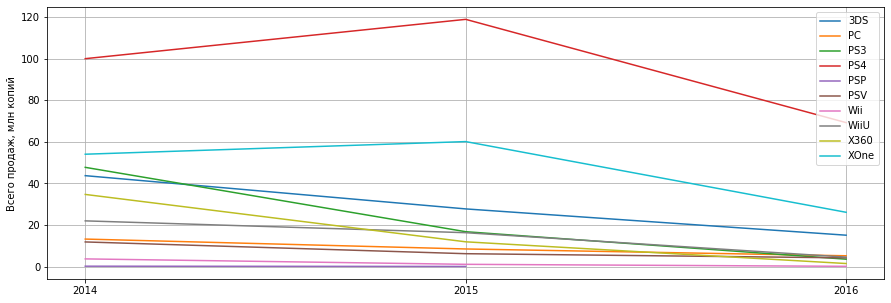

In [27]:
plt.figure(figsize=(15, 5))
for i in top_pl_period['platform'].unique():
    X = top_pl_period.loc[top_pl_period['platform'] == i, 'year_of_release']
    Y = top_pl_period.loc[top_pl_period['platform'] == i, 'total_sales']
    plt.plot(X, Y, label=i)
plt.legend()
plt.grid(True)
plt.ylabel('Всего продаж, млн копий')
plt.xticks([2014, 2015, 2016], [2014, 2015, 2016])
plt.show()

По количеству продаж лидируют:
1. PS4
2. XOne
3. 3DS

На 2016 для всех платформ характерен упадок. Но если предположить что данные по 2016 году неполные, более привлекательными вариантами будут являться:
1. PS4
2. XOne

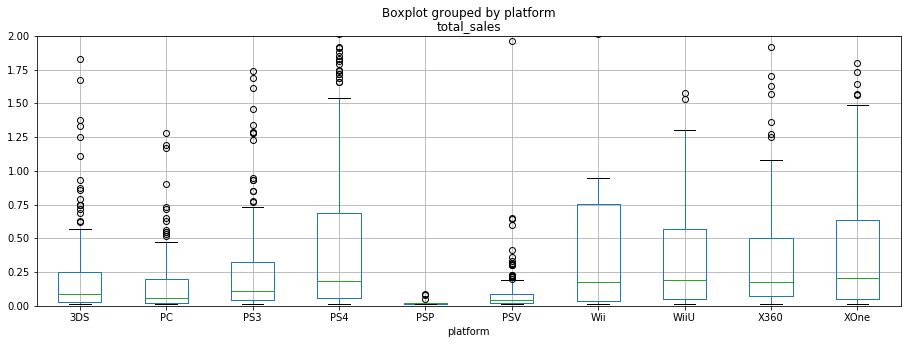

In [28]:
data_actual = data.loc[(data['year_of_release'] >= 2014) & (data['year_of_release'] <= 2016)]
data_actual.boxplot(column='total_sales', by='platform', figsize=(15,5)).set_ylim(0,2);

Как видно из распределения глобальных продаж по платформам, PS4 имеет не только больше всего проданных игр, но и каждая игра имеет больше продаж, чем на других платформах. У XOne дела обстоят хуже, ее ближайший конкурент по этим показателям WiiU. 

### Влияние отзывов

Оценим влияние на продажи внутри PS4 отзывов пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

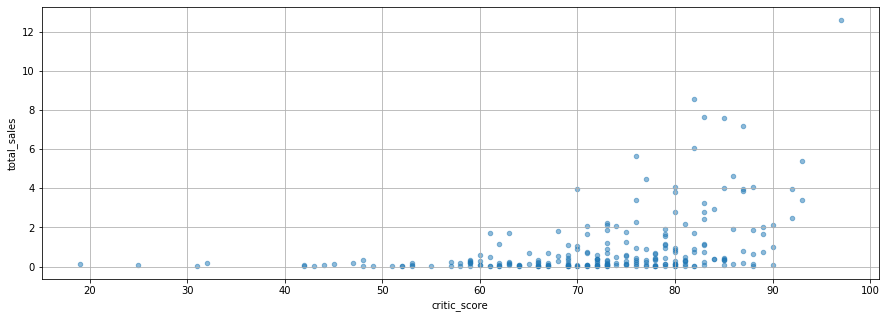

In [29]:
data_actual.loc[data_actual['platform'] == 'PS4'].plot(x='critic_score', y='total_sales', kind='scatter', 
                                         grid=True, figsize=(15,5), alpha = 0.5);

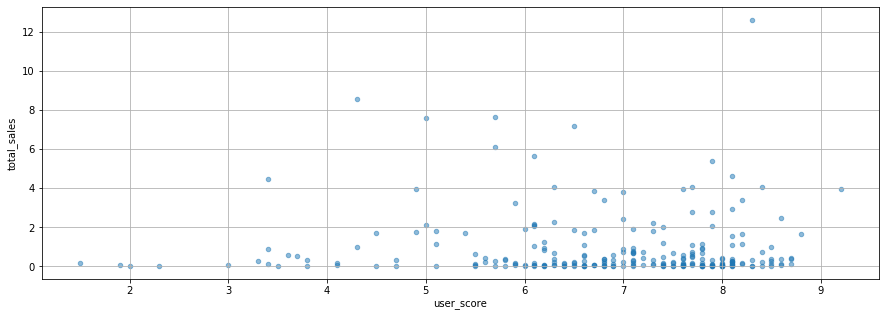

In [30]:
data_actual.loc[data_actual['platform'] == 'PS4'].plot(x='user_score', y='total_sales', kind='scatter', 
                                         grid=True, figsize=(15,5), alpha = 0.5);

In [31]:
data_actual.loc[data_actual['platform']=='PS4', ['total_sales','critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.402661,-0.040132
critic_score,0.402661,1.000000,0.546434
user_score,-0.040132,0.546434,1.000000


Как видно по диаграммам рассеяния и корреляции, глобальные продажи на PS4 имеют связь с оценками критиков, а связь с оценками пользователей близка к нулю.

In [32]:
data_actual.loc[data_actual['platform']=='XOne', ['total_sales','critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.428677,-0.070384
critic_score,0.428677,1.000000,0.440977
user_score,-0.070384,0.440977,1.000000


In [33]:
data_actual.loc[:, ['total_sales','critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.328105,-0.01307
critic_score,0.328105,1.000000,0.50446
user_score,-0.013070,0.504460,1.00000


Видимо критики лучше разбираются в области своей профессиональной деятельности, а также отзывы широко известных специалистов может иметь рекламный эффект для вышедших игр. Пользовательский рейтинг отражает вкусовщину.

### Жанры

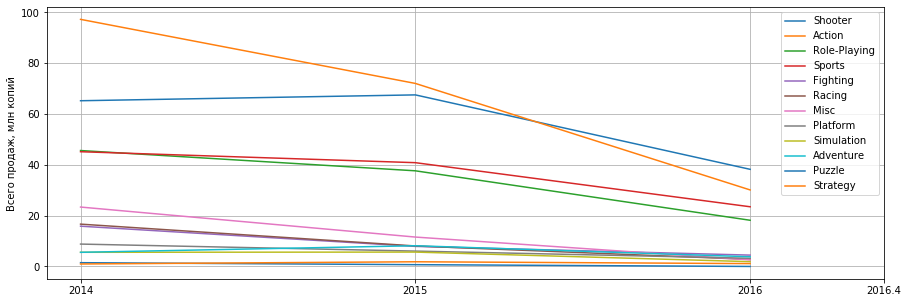

In [34]:
Y_arr = data_actual.groupby(by=['genre','year_of_release'])['total_sales'].sum()
plt.figure(figsize=(15, 5))
for genre in data_actual['genre'].unique():
    X = data_actual.loc[data['genre'] == genre,'year_of_release'].sort_values().unique()
    Y = Y_arr[genre]
    plt.plot(X, Y, label=genre, )
    plt.legend()
    plt.grid(True)
    plt.ylabel('Всего продаж, млн копий')
    plt.xticks([2014, 2015, 2016, 2016.4], [2014, 2015, 2016, 2016.4])
plt.show()

Наиболее популярны динамичные жанры, такие как Шутеры, Экшен, Спорт, Ролевые. Меньше всего продаж у Стратегий, Приключенческий игр и пазлов. В современных играх наиболее популярным и продаваемым жанром стали шутеры.

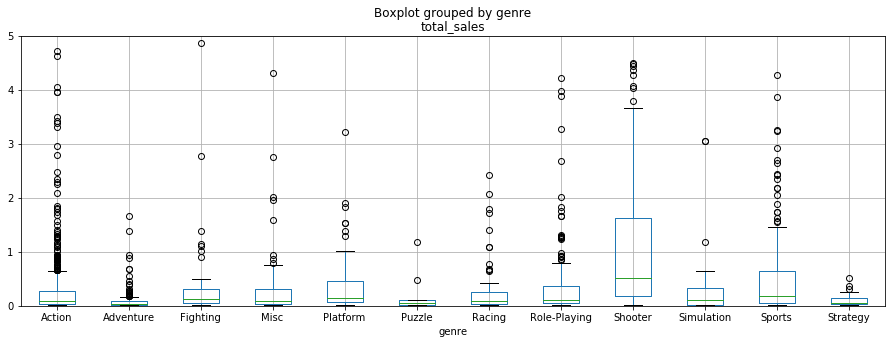

In [35]:
data_actual.boxplot(column='total_sales', by='genre', figsize=(15,5)).set_ylim(0,5);

В жанрах Экшен и Ролевых много игр с небольшим количеством продаж копий, в этом плане платформеры лучше.

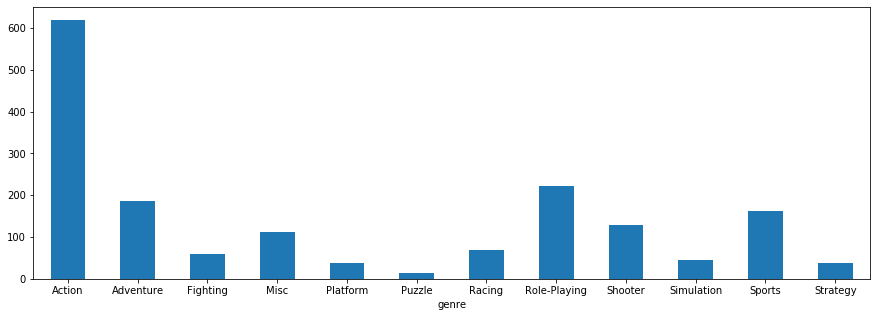

In [36]:
data_actual.groupby(by='genre')['genre'].count().plot(kind='bar', figsize=(15,5), rot=0);

Действительно, на рынке очень много игр жанра Экшен, хотя большая часть игр плохо продается, но есть и редкие бестселлеры. Меньше игр жанров Приключения, Ролевые, Спорт - среди них лучше продается Спорт. Далее Шутеры и Инди игры. Инди игры продаются на уровне Ролевых, а среди шутеров много бестселеров, в среднем они продаются лучше всех других жанров. 

### Вывод по разделу

Были выявлены следующие зависимости:
- Пик выпуска игр пришелся на 2005-2012 года, далее рынок упал в два раза.
- Платформы в среднем акутальны 5 лет, имеют пик популярности на 2-3 год.

Для прогноза на 2017 год, за актуальный период приняли 2014-2016.

Более привлекательным платформами являются:
1. PS4,
2. XOne.

Продажи игр имеют связь с высокими оценками критиков.

Наиболее прибыльный жанр: Шутеры. Наименее - Пазлы.

## Составление портрета пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP):
- Самые популярные платформы (топ-5);
- Самые популярные жанры (топ-5);
- Влияние рейтинга ESRB на продажи в отдельном регионе.

In [37]:
def portret_user(factor):
    for region in ['na_sales', 'eu_sales', 'jp_sales']:
        (
            data_actual.groupby(by=factor)[region]
            .sum()
            .sort_values(ascending=False)[0:5]
            .plot(kind='bar', title=region, figsize=(15,3), rot=0)
        )
        plt.show()

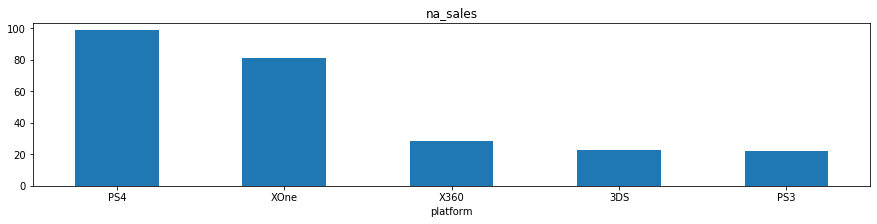

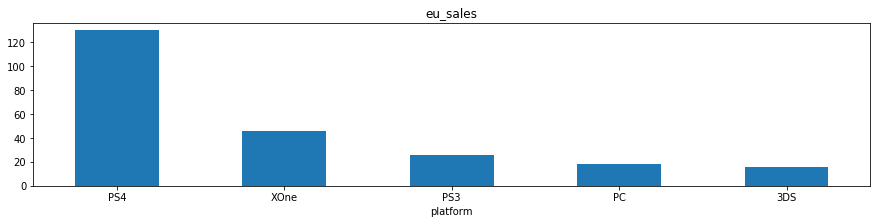

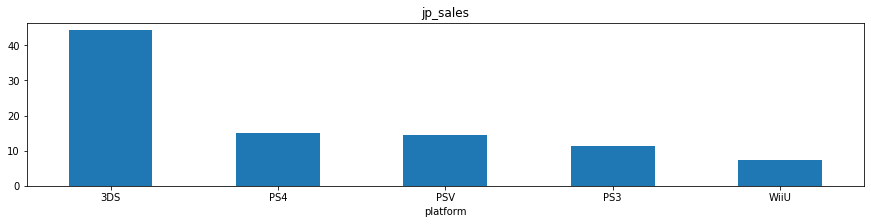

In [38]:
portret_user('platform')

Как видно по графикам, в акутальном периоде лидирующей платформой на американском и европейском рынках является PS4 - продукт компании Sony. Второе место на американском и европейском рынках занимает платформа от Microsoft - XOne. На японском рынке лидером является 3DS от Nintendo, далее продукция компании Sony. Объемы продаж игр на этих платформах отражают лучшие показатели на местных рынках, ориентированность и доминированик на европейском и американском рынке компании Sony.

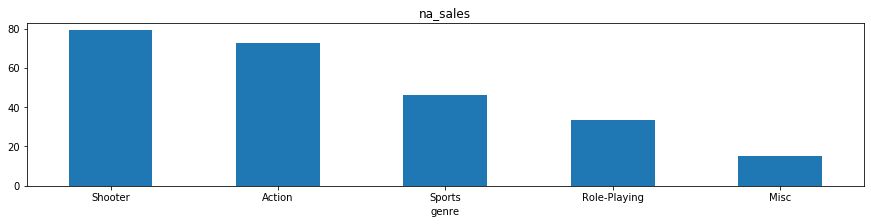

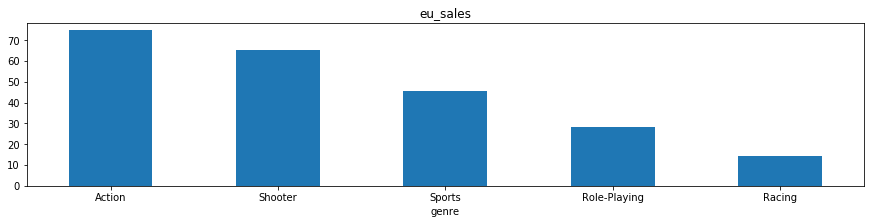

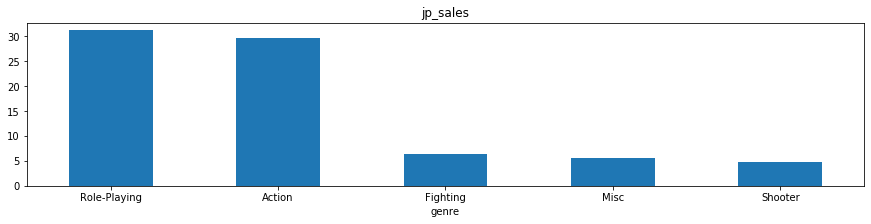

In [39]:
portret_user('genre')

Экшен, Шутеры, Спортивные и Ролевые игры явялются наиболее популярными на американском и европейском рынке, с той разницей, что в Америке более популярны Шутеры и менее популярны Инди игры, а в Европе - Экшен и Гонки.

На японском рынке самыми популярными жанрами являются Ролевые и Экшен. Далее значительно менее популярными являются жанры: Файтинг, Инди, Шутеры.

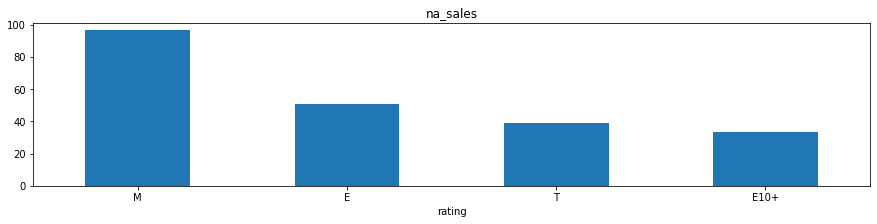

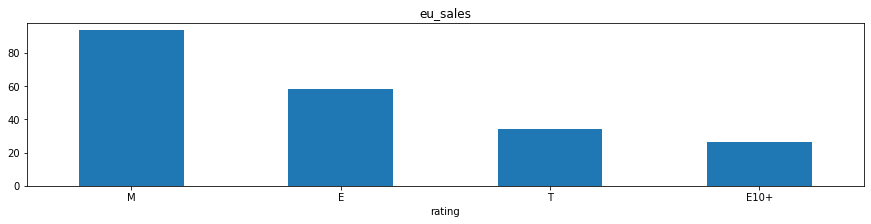

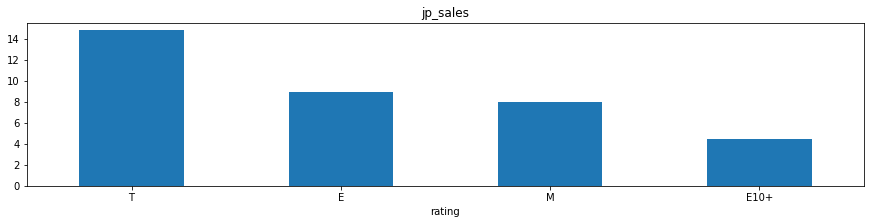

In [40]:
portret_user('rating')

In [41]:
print("Всего локальных продаж млн. копий за актуальный период:")
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    print(region, round(data_actual[region].sum(),2))

Всего локальных продаж млн. копий за актуальный период:
na_sales 284.06
eu_sales 270.68
jp_sales 93.09


In [42]:
top_pl = data_actual.groupby(by='platform')['total_sales'].sum().sort_values(ascending=False)[0:3].index
for platform in top_pl:
    print(platform, len(data_actual.loc[(data_actual['platform'] == platform) & (data_actual['rating'].isna())]))

PS4 136
XOne 59
3DS 138


Entertainment Software Rating Board (ESRB) — негосударственная организация, основное направление деятельности — принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде.

По япоскому рынку данных гораздо меньше по сравнию с другим, как из-за объема продаж, так и пропусков в рейтинге, что возможно из специфики организации дающей рейтинги.

Тем не менее ситуация на рынках следующая: наиболее продаваемые игры рейтинга M (для взрослых), на японском рынке - Т (для подростков), вторая позиция E (для всех), и менее популярны игры с рейтингом E10+ (Для всех от 10 и старше). 

Можно предположить, что на японском рынке игроки преимущественно подростки, а на других рынках взрослые, но данные могут быть искажены из-за пропусков. Американские и Европейские рынки не в этом отношении не отличаются.

## Проверка гипотез

Проверка гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам - применим t-test, метод ttest_ind(). Сформируем нулевые и альтернативные гипотезы по принципу что за нулевую гипотизу принимается равенство сравниваемых выборок, а альтернативная гипотеза противоположна нулевой. Зададим критерий статистической значимости, определим выборки и проведем проверки гипотез.

### Средние пользовательские рейтинги платформ Xbox One и PC

- H0 = Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
- H1 = Средние пользовательские рейтинги платформ Xbox One и PC не одинаковые.
- alpha = 0.05

In [43]:
x_one = data_actual.loc[(data_actual['platform'] == 'XOne') & (~data_actual['user_score'].isna()), 'user_score']
pc = data_actual.loc[(data_actual['platform'] == 'PC') & (~data_actual['user_score'].isna()), 'user_score']
print(len(x_one), len(pc))

165 122


In [44]:
results = st.ttest_ind(x_one, pc, equal_var = False) # Выбоорки разного размера - equal_var=False
alpha = 0.05
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение:  0.11601398086668835
Не получилось отвергнуть нулевую гипотезу


Пользователи Xbox One и персональных компьютеров по-разному оценивают компьютерные игры. 

### Средние пользовательские рейтинги жанров Action и Sports

- H0 = Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые.
- H1 = Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
- alpha = 0.05

In [45]:
action = data_actual.loc[(data_actual['genre'] == 'Action') & (~data_actual['user_score'].isna()), 'user_score']
sports = data_actual.loc[(data_actual['genre'] == 'Sports') & (~data_actual['user_score'].isna()), 'user_score']
print(len(action), len(sports))

297 127


In [46]:
results = st.ttest_ind(action, sports, equal_var=False) # Выбоорки разного размера - equal_var=False
alpha = 0.05
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение:  1.1825550382644557e-14
Отвергаем нулевую гипотезу


Пользователи по-разному оценивают игры жанров Action и Sports.

### Вывод по разделу

1. Пользователи Xbox One и персональных компьютеров по-разному оценивают компьютерные игры. 
2. Пользователи по-разному оценивают игры жанров Action и Sports.


## Вывод 

В данном исследовании: 
1. Были заменены названия столбцов;
2. Преобразованы данные в нужные типы;
3. Обработаны пропуски;
4. Посчитаны суммарные продажи во всех регионах.

Были выявлены следующие зависимости:
- Пик выпуска игр пришелся на 2005-2012 года, далее рынок упал в два раза.
- Платформы в среднем акутальны 5 лет, имеют пик популярности на 2-3 год.

Для прогноза на 2017 год, за актуальный период приняли 2014-2016.

Более привлекательным платформами являются:
1. PS4,
2. XOne.

Продажи игр имеют связь с высокими оценками критиков.

Наиболее прибыльный жанр: Шутеры. Наименее - Пазлы.

__Платформы:__ Лидирующей платформой на американском и европейском рынках является PS4 - продукт компании Sony. Второе место на американском и европейском рынках занимает платформа от Microsoft - XOne. На японском рынке лидером является 3DS от Nintendo, далее продукция компании Sony. Объемы продаж игр на этих платформа отражают лучшие показатели на местных рынках, ориентированность и доминированик на европейском и американском рынке компании Sony.

__Жанры:__ Экшен, Шутеры, Спортивные и Ролевые игры явялются наиболее популярными на американском и европейском рынке, с той разницей, что в Америке более популярны Шутеры и менее популярны Инди игры, а в Европе - Экшен и Гонки. На японском рынке самыми популярными жанрами являются Ролевые и Экшен. Далее значительно менее популярными являются жанры: Файтинг, Инди, Шутеры.

__Рейтинг ESRB:__ По япоскому рынку данных гораздо меньше по сравнию с другим, как из-за объема продаж, так и пропусков в рейтинге, что возможно из специфики организации дающей рейтинги. Тем не менее ситуация на рынках следующая: наиболее продаваемые игры рейтинга M (для взрослых), на японском рынке - Т (для подростков), вторая позиция E (для всех), и менее популярны игры с рейтингом E10+ (Для всех от 10 и старше). Можно предположить, что на японском рынке игроки преимущественно подростки, а на других рынках взрослые, но данные могут быть искажены из-за пропусков. Американские и Европейские рынки не в этом отношении не отличаются.

Проверка гипотез показала, что:
1. Пользователи Xbox One и персональных компьютеров по-разному оценивают компьютерные игры. 
2. Пользователи по-разному оценивают игры жанров Action и Sports.